In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn import preprocessing
# from google.colab import files
from sklearn.linear_model import LogisticRegression
from scipy import stats
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from xgboost import XGBClassifier
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import chi2
%matplotlib inline
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')

# **Data Preprocessing**

### **Step 1** - **Finding Null values**

*   Training Set
*   Test Set



Training Set


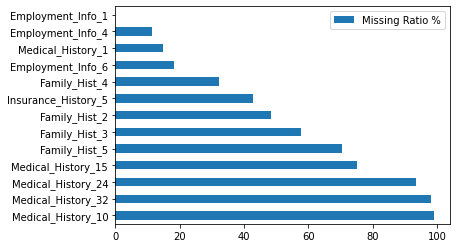




Test Set


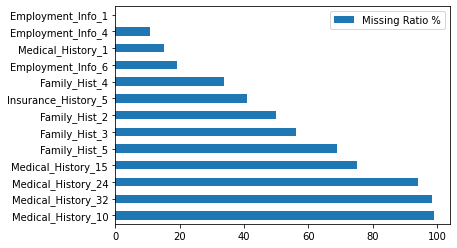

In [8]:
print("Training Set")
plot_nas(train_df)
print("\n\n")
print("Test Set")
plot_nas(test_df)

#### **Here we set our null value threshold to 40% and remove all the features above the threshhold. The features below the threshold will be imputed by calculating their skewness and the imputing null values with mean (if data is not skewed), median (data is skewed and feature is in numerical format) and mode (if data is skewed and the feature is in categorical format). Some measure skewness when mean == median**

Training Set


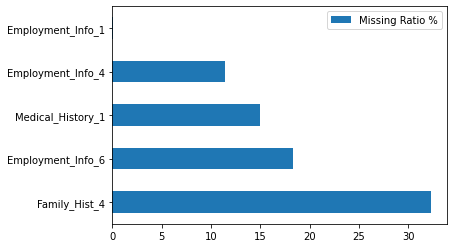

Test Set


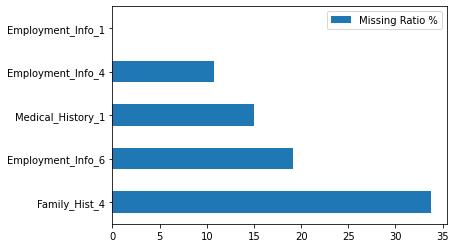

In [9]:
train_df = train_df.drop(['Insurance_History_5','Family_Hist_2','Family_Hist_3', 'Family_Hist_5', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32', 'Medical_History_10'], axis=1)
test_df = test_df.drop(['Insurance_History_5','Family_Hist_2','Family_Hist_3', 'Family_Hist_5', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32', 'Medical_History_10'], axis=1)

print("Training Set")
plot_nas(train_df)
print("Test Set")
plot_nas(test_df)

Mean:  0.07758209953084466
Median:  0.06


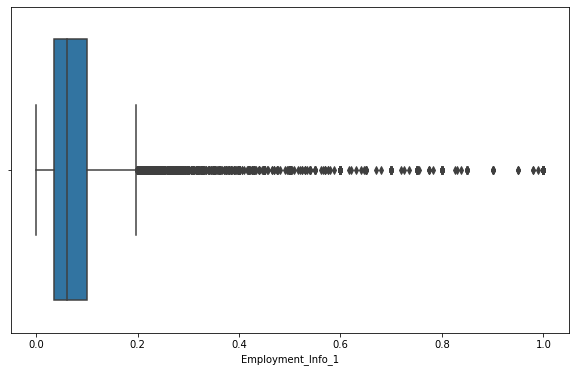

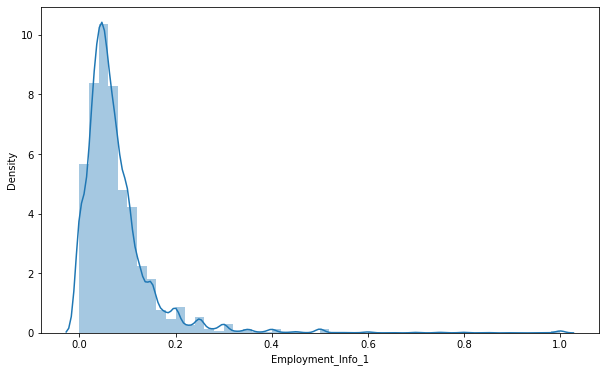

In [10]:
cols = ['Employment_Info_1', 'Employment_Info_4', 'Medical_History_1', 'Employment_Info_6', 'Family_Hist_4']

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(train_df[cols[0]])

fig, ax = plt.subplots(figsize = (10,6))
sns.distplot(train_df[cols[0]])

print("Mean: ",train_df[cols[0]].mean())
print("Median: ",train_df[cols[0]].median())

#Since the data is skewed towards left, we use mean to impute data
mean = train_df[cols[0]].mean()
train_df[cols[0]] = train_df[cols[0]].fillna(mean)

#Since the data values in all cells are either 0 or very close to 0 we'll drop the column 
train_df = train_df.drop([cols[1]], axis=1)
test_df = test_df.drop([cols[1]], axis=1)

#Since the data is skewed towards left, we use mean to impute data
mean = train_df[cols[2]].mean()
train_df[cols[2]] = train_df[cols[2]].fillna(mean)

#Since the data is skewed towards left, we use mean to impute data
mean = train_df[cols[3]].mean()
train_df[cols[3]] = train_df[cols[3]].fillna(mean)

#Since the data is skewed and follows normal distribution i.e mean == median, we use median (numeric) and median (categorical) to impute data
mean = train_df[cols[4]].median()
train_df[cols[4]] = train_df[cols[4]].fillna(mean)

#Test Dataset
cols_test = ['Medical_History_1', 'Employment_Info_6', 'Family_Hist_4', 'Employment_Info_1']

#Since the data is skewed towards left, we use mean to impute data
mean = test_df[cols_test[0]].mean()
test_df[cols_test[0]] = test_df[cols_test[0]].fillna(mean)

#Since the data is skewed towards left, we use mean to impute data
mean = test_df[cols_test[1]].mean()
test_df[cols_test[1]] = test_df[cols_test[1]].fillna(mean)

#Since the data is normal, we use median to impute data
mean = test_df[cols_test[2]].median()
test_df[cols_test[2]] = test_df[cols_test[2]].fillna(mean)

#Since the data is skewed towards left, we use mean to impute data
mean = test_df[cols_test[3]].mean()
test_df[cols_test[3]] = test_df[cols_test[3]].fillna(mean)

In [11]:
plot_nas(train_df)
plot_nas(test_df)

No NAs found
No NAs found


### **Label Encoding on categorical Column**

In [15]:
from sklearn import preprocessing

labelencoder = preprocessing.LabelEncoder()

train_df['Product_Info_2'] = labelencoder.fit_transform(train_df['Product_Info_2'])
test_df['Product_Info_2'] = labelencoder.fit_transform(test_df['Product_Info_2'])
train_df['Product_Info_2']

0        16
1         0
2        18
3        17
4        15
         ..
59376    14
59377    16
59378    18
59379    15
59380     7
Name: Product_Info_2, Length: 59381, dtype: int64

### **We will now remove outliers, but before that we will store the dataframe with outliers, which we will use further to check if we just need to check for outliers**

In [16]:
test_df_outliers = test_df
train_df_outliers = train_df

def box_plot(df, feature):
  df.boxplot(column = feature)
  plt.grid(False)
  plt.show()

def outliers(df, feature):
  q1 = df[feature].quantile(0.25)
  q3 = df[feature].quantile(0.75)

  inter_quantile_range = q3 - q1

  #here 1.5 being the default scale value
  lower_boundary = q1 - 1.5 * inter_quantile_range
  upper_bounary =  q3 + 1.5 * inter_quantile_range

  outliers_index = df.index[(df[feature] < lower_boundary) | (df[feature] > upper_bounary)]
  return outliers_index

def remove_out(df, indexlst):
  #sort the list and remove duplicate values && set returns non-repeating elements
  indexlst = sorted(set(indexlst))
  df = df.drop(indexlst)
  return df

In [17]:
cols = train_df.columns
cols_lst = cols.tolist()
cols_lst.remove('Product_Info_2')
cols_lst.remove('Response')

index_list = []

#Here we will xclude Response since it is target variable
for feature in cols_lst:
  # .append() adds a single element to the end of the list while .extend() can add multiple individual elements to the end of the list.
  index_list.extend(outliers(train_df, feature))

In [18]:
df_cleaned = remove_out(train_df, index_list)
df_cleaned

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
52,76,1,16,26,0.076923,2,3,1,0.402985,0.781818,...,0,0,0,0,0,0,0,0,0,6
74,108,1,15,26,0.128205,2,3,1,0.626866,0.709091,...,0,0,0,0,0,0,0,0,0,6
83,118,1,17,26,0.230769,2,3,1,0.164179,0.763636,...,0,0,0,0,0,0,0,0,0,7
94,132,1,17,26,0.282051,2,3,1,0.283582,0.763636,...,0,0,0,0,0,0,0,0,0,6
161,221,1,16,26,0.076923,2,3,1,0.567164,0.654545,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59299,79044,1,17,26,0.230769,2,3,1,0.298507,0.581818,...,0,0,0,0,0,0,0,0,0,8
59323,79079,1,14,26,0.333333,2,3,1,0.119403,0.727273,...,0,0,0,0,0,0,0,0,0,7
59331,79092,1,0,26,0.230769,2,3,1,0.119403,0.672727,...,0,0,0,0,0,0,0,0,0,8
59345,79109,1,14,26,0.076923,2,3,1,0.477612,0.709091,...,0,0,0,0,0,0,0,0,0,4


### **We will now check for Correlation and drop features with least correlation**

Text(0.5, 1.0, 'Correlation between different features')

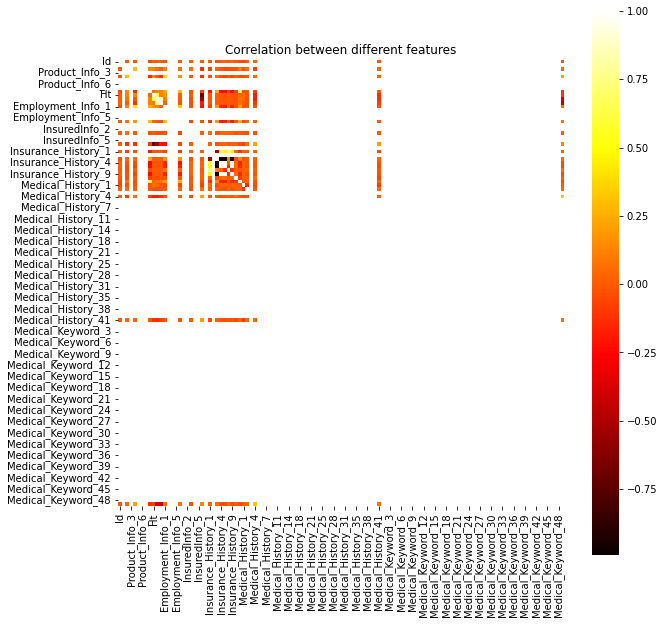

In [20]:
correlation = df_cleaned.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True, cmap='hot')

plt.title('Correlation between different features')

### **Since the feature set is large and we cannot deduce the correlation we calculate feature score using Mutual independence Chi-square**

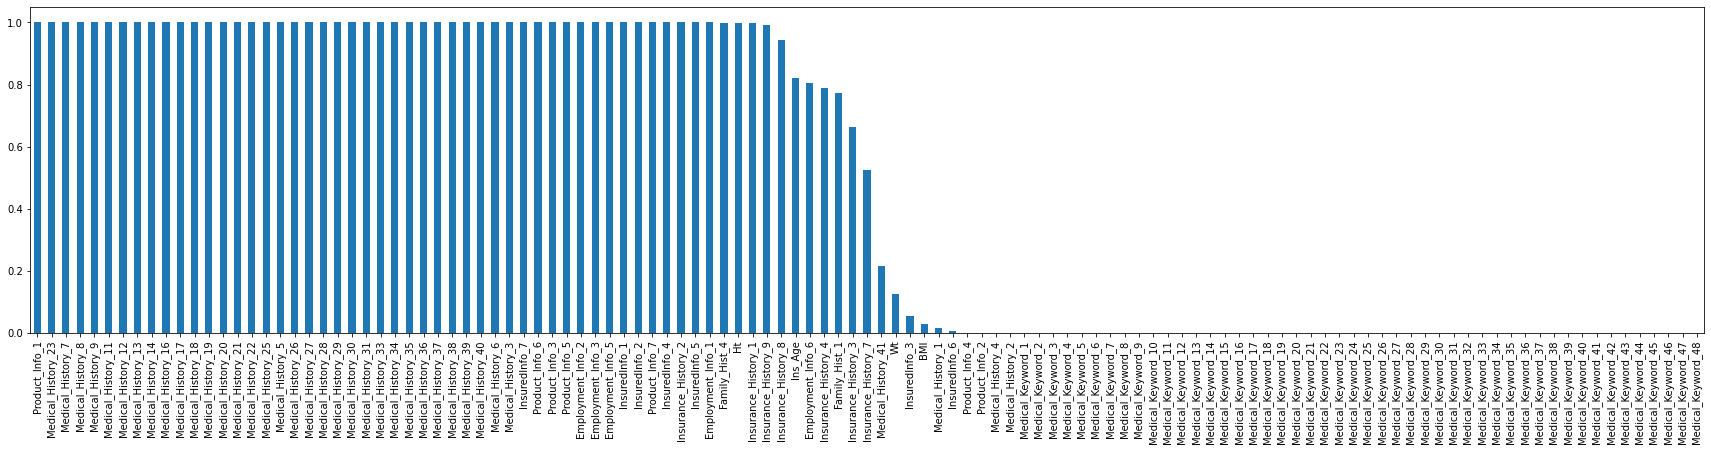

In [ ]:
response_train = df_cleaned['Response']
y = df_cleaned['Response']
X = df_cleaned.drop(['Id', 'Response'], axis=1)

chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
fig, ax = plt.subplots(figsize = (30,6))
p_values.plot.bar()

### **Now as we can see some columns have very low importance so we can drop them and then Normalise the data**

In [ ]:
col_drop = []
col_drop.append('Product_Info_4')
col_drop.append('Product_Info_2')
col_drop.append('Medical_History_2')
for i in range(1,49):
  a = "Medical_Keyword_"+str(i)
  col_drop.append(a)

df_cleaned = df_cleaned.drop(col_drop, axis=1)
print(df_cleaned.shape)
cols = df_cleaned.columns

#Test data
test_df = test_df.drop(col_drop, axis=1)
print("Test Data: ",test_df.shape)

d = preprocessing.normalize(df_cleaned)
scaled_df = pd.DataFrame(d, columns=cols)

d1 = preprocessing.normalize(test_df)
test_df = pd.DataFrame(d1, columns=test_df.columns)

scaled_df

(2000, 68)
Test Data:  (19765, 67)


,Id,Product_Info_1,Product_Info_3,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,...,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Response
0,0.915299,0.012043,0.313129,0.024087,0.036130,0.012043,0.004853,0.009416,0.004737,0.006691,...,0.036130,0.036130,0.012043,0.024087,0.024087,0.012043,0.036130,0.036130,0.012043,0.072260
1,0.956620,0.008858,0.230297,0.017715,0.026573,0.008858,0.005553,0.006281,0.003298,0.005394,...,0.026573,0.026573,0.008858,0.017715,0.017715,0.008858,0.026573,0.026573,0.008858,0.053146
2,0.955592,0.008098,0.210554,0.016196,0.024295,0.008098,0.001330,0.006184,0.002931,0.004268,...,0.024295,0.024295,0.008098,0.016196,0.016196,0.008098,0.024295,0.024295,0.008098,0.056688
3,0.970375,0.007351,0.191134,0.014703,0.022054,0.007351,0.002085,0.005614,0.002568,0.003729,...,0.022054,0.022054,0.007351,0.014703,0.014703,0.007351,0.022054,0.022054,0.007351,0.044108
4,0.989200,0.004476,0.116376,0.008952,0.013428,0.004476,0.002539,0.002930,0.000824,0.001476,...,0.013428,0.013428,0.004476,0.008952,0.008952,0.004476,0.013428,0.013428,0.013428,0.031332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000004,0.000007,0.000002,0.000004,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000101
1996,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000002,0.000009,0.000005,0.000007,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000089
1997,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000002,0.000009,0.000003,0.000004,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000101
1998,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000006,0.000009,0.000004,0.000006,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000051


In [ ]:
response = df_cleaned['Response']
y_train = df_cleaned['Response']
X_train = scaled_df.drop(['Id', 'Response'], axis=1)

test_df.columns
X_test = test_df.drop('Id', axis=1)

### **Now we can use GridSearch to crossvalidate the params within multiple models**

In [ ]:
param_grid= {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],'C': [0.1,1,10,100]}
base_estimator = SVC(gamma='scale')
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

SVC(C=0.1, kernel='poly')

In [ ]:
clf = SVC(kernel='poly', C=0.1)
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print(pred)

[2 7 6 ... 8 8 8]


In [ ]:
param_grid= {'C':[0.1,1,10],
    'max_iter':[100,200,300,400],
    'tol':[0.0001,0.001,0.1,1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
base_estimator = LogisticRegression()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')

In [ ]:
model= LogisticRegression(multi_class='ovr', solver='newton-cg',C=0.1)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)

[8 8 8 ... 8 8 8]


In [ ]:
param_grid= {'loss': ['huber','squared_error','epsilon_insensitive','squared_epsilon_insensitive'],'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 1], 'learning_rate': ['constant','optimal','invscaling','adaptive']}
base_estimator = SGDRegressor()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

SGDRegressor(alpha=0.01, learning_rate='constant', penalty='elasticnet')

In [ ]:
model= SGDRegressor(alpha=0.001, loss='squared_epsilon_insensitive', penalty='l1')
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)

[6.61238923 6.61238923 6.61238923 ... 6.61238923 6.61238923 6.61238923]


In [ ]:
param_grid= {'alpha': [0.1,1,10]}
base_estimator = linear_model.Lasso()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

Lasso(alpha=0.1)

In [ ]:
model= linear_model.Lasso(alpha=0.1)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)

[6.6185 6.6185 6.6185 ... 6.6185 6.6185 6.6185]


In [ ]:
param_grid= {'alpha': [0.1,1,10]}
base_estimator = linear_model.Lasso()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

Lasso(alpha=0.1)

In [ ]:
model= LinearRegression()
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)

[ 37.87890284 102.02993945 -85.1966385  ...   6.61229155   6.62832634
   6.56861897]


In [ ]:
#We think maybe in this data anomaly prediction is very important so we have also predicted anomalies
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(X_test)

IsolationForest(contamination=0.1, n_estimators=50)

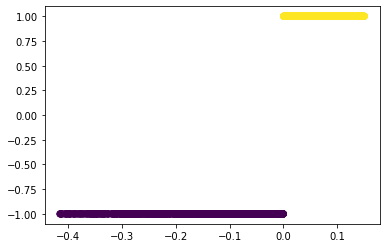

In [ ]:
df = pd.DataFrame()
df['scores']=model.decision_function(X_test)
df['anomaly']=model.predict(X_test)
df.head(20)
plt.scatter(df['scores'], df['anomaly'], c=df['anomaly'])